In [6]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import numpy as np

from doobs_score_matching.src.models import score_mlp
import orbax.checkpoint
from src.training import train_utils
from src.sdes import sde_utils, time

from src.sdes import sde_kunita

Setup to load in checkpoint

In [7]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()

T = 1.0
N = 100

def get_score(checkpoint_path):
    orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
    restored = orbax_checkpointer.restore(checkpoint_path)
    model = score_mlp.ScoreMLP(**restored["network"])
    params = restored["params"]
    batch_stats = restored["batch_stats"]
    trained_score = train_utils.trained_score(model, params, batch_stats)
    return trained_score


In [8]:
num_landmarks = 2

checkpoint_path = f"../../checkpoints/kunita/fixed_y_lms_{num_landmarks}"
trained_score = get_score(checkpoint_path)

In [9]:
keys = jax.random.split(jax.random.PRNGKey(0), 10)
ts = time.grid(0, T, N)

def sample_circle(num_landmarks: int, radius=1.0, centre=jnp.asarray([0, 0])) -> jnp.ndarray:
    theta = jnp.linspace(0, 2 * jnp.pi, num_landmarks, endpoint=False)
    x = jnp.cos(theta)
    y = jnp.sin(theta)
    return (radius * jnp.stack([x, y], axis=1) + centre).flatten()

# x0 = sample_circle(num_landmarks, 1.2)

y = jnp.asarray([-0.5, 0., 0.5, 0.0])
target = y.reshape(-1, 2)

x0 = jnp.asarray([-0.7, 0., 0.4, 0.0])

drift, diffusion = sde_kunita.vector_fields()
bm_shape = (sde_kunita.GRID_SIZE**2 * 2,)

conditioned_trajs = jax.vmap(sde_utils.conditioned, (0, None, None, None, None, None, None))(keys, ts, x0, trained_score, drift, diffusion, bm_shape)

forward_trajs = jax.vmap(sde_utils.solution, (0, None, None, None, None, None))(keys, ts, x0, drift, diffusion, bm_shape)


# conditioned_traj = sde_utils.conditioned(key, ts, x0, trained_score, drift, diffusion, bm_shape)
# forward_traj = sde_utils.solution(key, ts, x0, drift, diffusion, bm_shape)

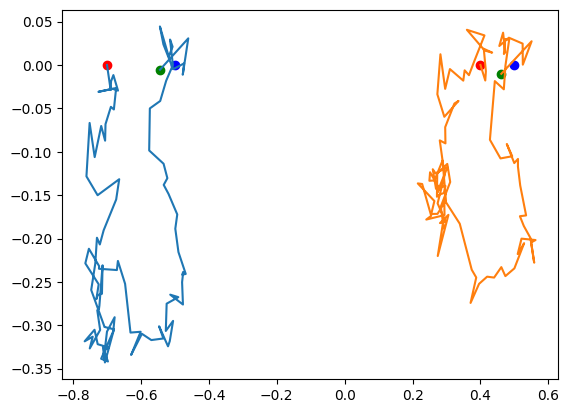

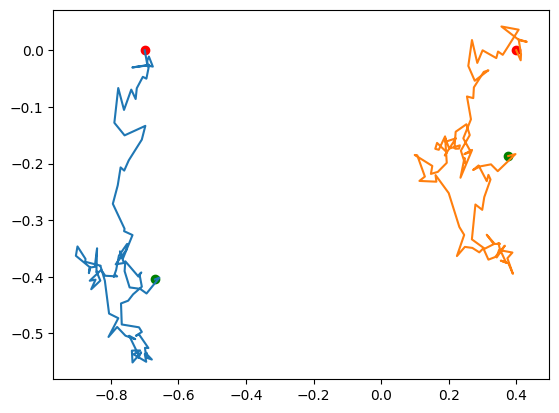

In [11]:
traj = 5
conditioned_traj = conditioned_trajs[traj].reshape(-1, 2, 2)

for landmark in range(conditioned_traj.shape[1]):
    plt.plot(conditioned_traj[:, landmark, 0], conditioned_traj[:, landmark, 1])
    plt.scatter(conditioned_traj[0, landmark, 0], conditioned_traj[0, landmark, 1], c='red')
    plt.scatter(conditioned_traj[-1, landmark, 0], conditioned_traj[-1, landmark, 1], c='green')
    plt.scatter(target[landmark, 0], target[landmark, 1], c='blue')
plt.show()

forward_traj = forward_trajs[traj].reshape(-1, 2, 2)

for landmark in range(forward_traj.shape[1]):
    plt.plot(forward_traj[:, landmark, 0], forward_traj[:, landmark, 1])
    plt.scatter(forward_traj[0, landmark, 0], forward_traj[0, landmark, 1], c='red')
    plt.scatter(forward_traj[-1, landmark, 0], forward_traj[-1, landmark, 1], c='green')
plt.show()